In [ ]:
import pandas as pd
from arch import arch_model

# Assuming your data is already cleaned and prepared
# Replace 'your_dataframe' with the actual DataFrame variable name containing the data
# For example, if your DataFrame is named 'regression_data_cleaned', use it directly
data = regression_data_cleaned

# Prepare the dependent variable (returns) and exogenous variables (sentiment indicators)
y = data['Return']
exog = data[['Bullish_sentiment', 'Bearish_sentiment', 'Neutral_sentiment', 'Spread_sentiment', 'Mov Avg_sentiment']]

# Create the GARCH model with sentiment indicators as exogenous variables
mod = arch_model(y, x=exog, mean='ARX', lags=1)
res = mod.fit(disp='off')

# Print the summary of the model results
print(res.summary())


In [13]:
import pandas as pd
from arch import arch_model

# Load the data from the provided CSV file
file_path = 'data.csv'
data = pd.read_csv(file_path)

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Calculate daily returns
data['Return'] = data['Close'].pct_change()

# Calculate rolling volatility (standard deviation of returns)
data['Volatility'] = data['Return'] ** 2  # 21 trading days in a month

# Drop rows with missing values due to rolling calculations
regression_data = data.dropna(subset=['Return', 'Bullish_sentiment', 'Bearish_sentiment', 'Neutral_sentiment', 
                                      'Spread_sentiment', 'Mov Avg_sentiment', 'Volatility'])

# Remove rows with missing volatility values
regression_data_cleaned = regression_data.dropna(subset=['Volatility'])

# Prepare the dependent variable (returns) and exogenous variables (sentiment indicators) for the GARCH model
y_returns = regression_data_cleaned['Volatility'] * 1000
exog_vars = regression_data_cleaned[['Bullish_sentiment', 'Bearish_sentiment', 'Neutral_sentiment', 'Spread_sentiment', 'Mov Avg_sentiment']]

# Create the GARCH model with sentiment indicators as exogenous variables
mod = arch_model(y_returns, x=exog_vars, mean='ARX', lags=1)
res = mod.fit(disp='off')

# Print the summary of the model results
print(res.summary())


                          AR-X - GARCH Model Results                          
Dep. Variable:             Volatility   R-squared:                       0.056
Mean Model:                      AR-X   Adj. R-squared:                  0.055
Vol Model:                      GARCH   Log-Likelihood:                1236.12
Distribution:                  Normal   AIC:                          -2452.24
Method:            Maximum Likelihood   BIC:                          -2385.04
                                        No. Observations:                 6125
Date:                Mon, May 27 2024   Df Residuals:                     6118
Time:                        20:49:32   Df Model:                            7
                                    Mean Model                                   
                        coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------------------------------------------------
Const                36.4200      2.752    

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Load the data from the provided CSV file
file_path = 'data.csv'
data = pd.read_csv(file_path)

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Calculate daily returns
data['Return'] = data['Close'].pct_change()

data["Volatility"] = data["Return"] ** 2

# Drop rows with missing values
data = data.dropna()

In [2]:

# Select features and target
features = data[['Bullish_sentiment', 'Bearish_sentiment', 'Neutral_sentiment', 'Spread_sentiment', 'Mov Avg_sentiment']].values
target = data['Volatility'].values.reshape(-1, 1)

# Normalize the data
scaler_x = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler_x.fit_transform(features)

scaler_y = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_y.fit_transform(target)

# Create sequences for LSTM
def create_sequences(features, target, time_step=1):
    X, y = [], []
    for i in range(len(features)-time_step-1):
        X.append(features[i:(i+time_step), :])
        y.append(target[i + time_step])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_sequences(features_scaled, target_scaled, time_step)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [4]:
# Build the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(time_step, X.shape[2])))
model.add(LSTM(25, return_sequences=True))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

C:\environments\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [88]:

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Loss: {train_loss}")
print(f"Test Loss: {test_loss}")

Epoch 1/10


C:\environments\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.4823e-04 - val_loss: 0.0024
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.2228e-04 - val_loss: 0.0024
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.5964e-04 - val_loss: 0.0024
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 9.8279e-04 - val_loss: 0.0024
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.5390e-04 - val_loss: 0.0024
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.1737e-04 - val_loss: 0.0024
Train Loss: 0.0009878571145236492
Test Loss: 0.00236852397210896


In [89]:

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values
train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)
y_train_actual = scaler_y.inverse_transform(y_train)
y_test_actual = scaler_y.inverse_transform(y_test)

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


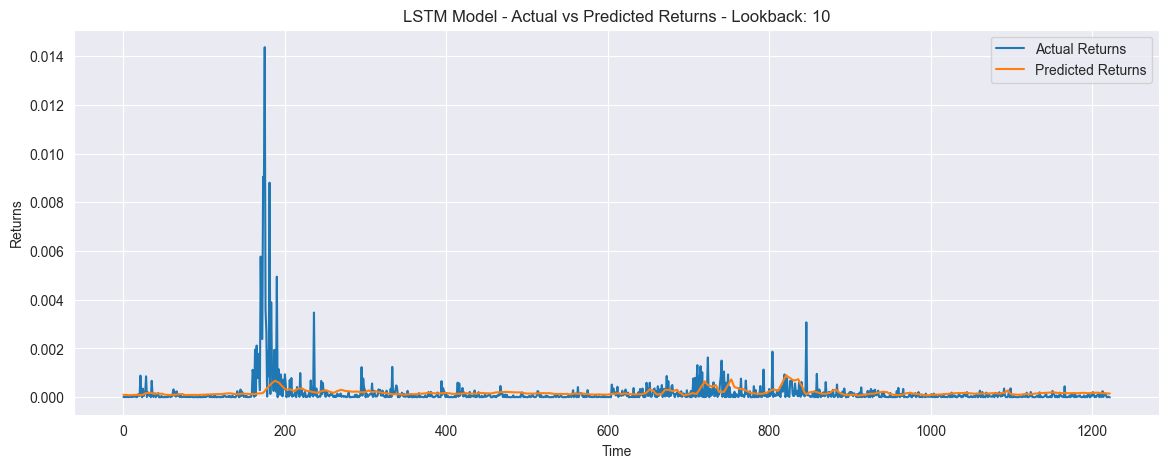

In [90]:

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
# plt.plot(y_train_actual, label='Actual Returns - train')
# plt.plot(train_predict, label='Predicted Returns - train')
plt.plot(y_test_actual, label='Actual Returns')
plt.plot(test_predict, label='Predicted Returns')
plt.title(f'LSTM Model - Actual vs Predicted Returns - Lookback: {time_step}')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()


In [84]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Calculate R2, MSE, RMSE, MAE for the test set
r2 = r2_score(y_test_actual, test_predict)
mse = mean_squared_error(y_test_actual, test_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, test_predict)
#y_test_actual = [x for x in y_test_actual if x != 0]
mape = mean_absolute_percentage_error(y_test_actual, test_predict)

print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

R²: 0.026769974727127166
MSE: 4.881366671929725e-07
RMSE: 0.0006986677802739815
MAE: 0.0001778256402420003
MAPE: 2059.15837157828


In [54]:
data["Volatility"].mean()

0.00015114984996226236

In [56]:
0.000156/ 0.000151

1.033112582781457

In [7]:
# Plot the model
import pydot_ng
import graphviz
from tensorflow.keras.utils import plot_model



plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

# Load the data from the provided CSV file
file_path = 'data.csv'  # Update this path to your local file
data = pd.read_csv(file_path)

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Calculate daily returns
data['Return'] = data['Close'].pct_change()
data["Volatility"] = data["Return"] ** 2


# Drop rows with missing values
data = data.dropna()

# Prepare the data for polynomial regression
X_poly = data[['Bullish_sentiment', 'Bearish_sentiment', 'Neutral_sentiment', 'Spread_sentiment', 'Mov Avg_sentiment']]
y_poly = data['Volatility']

# Generate polynomial features (degree 2 for this example)
poly = PolynomialFeatures(degree=2)
X_poly_transformed = poly.fit_transform(X_poly)
X_poly_transformed = sm.add_constant(X_poly_transformed)  # Add a constant term for intercept

# Fit the polynomial regression model using statsmodels
poly_model_sm = sm.OLS(y_poly, X_poly_transformed).fit()

# Get the summary of the model
poly_model_summary = poly_model_sm.summary()
print(poly_model_summary)


                            OLS Regression Results                            
Dep. Variable:             Volatility   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     40.86
Date:                Wed, 29 May 2024   Prob (F-statistic):          8.50e-108
Time:                        20:02:53   Log-Likelihood:                 37830.
No. Observations:                6126   AIC:                        -7.563e+04
Df Residuals:                    6111   BIC:                        -7.553e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.1503    203.917     -0.069      0.9